# **OBD2 데이터를 활용한 연비 예측 모델 만들기**

## **학습 목표**

- 연료 효율성(MPG or L/100km)을 측정한다. 회귀 분석을 사용하여 측정값이 연비와 어떤 관계가 있는지 알아보는 모델을 구축한다.

## 필요 패키지 설치

In [1]:
!pip3 install seaborn
!pip3 install xgboost
!pip3 install torchinfo

In [2]:
import seaborn as sns
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import MinMaxScaler as mms

## 데이터 및 변수명 불러오기

In [3]:
path = '../../favorite/엔진 모니터링을 위한 OBD-2 데이터 - automotive.txt'
data = pd.read_csv(path)
data.rename(columns={'Calculated instant fuel consumption (MPG)':"MPG"},inplace=True)
data.columns
data

,time,Average fuel consumption (MPG),Average fuel consumption (total) (MPG),Average fuel consumption 10 sec (MPG),Average speed (mph),MPG,Calculated instant fuel rate (gal./h),Distance travelled (miles),Distance travelled (total) (miles),Engine RPM (rpm),...,Fuel used price ($),Fuel used price (total) ($),Instant engine power (based on fuel consumption) (hp),MAF air flow rate (g/sec),Oxygen sensor 1 Wide Range Current (mA) (mA),Oxygen sensor 1 Wide Range Equivalence ratio (),Throttle position (%),Vehicle acceleration (g),Vehicle speed (mph),Unnamed: 22
0,07:57:49.962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.011719,14.702742,NaN,NaN,NaN,NaN
1,07:57:50.227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10.588235,NaN,NaN,NaN
2,07:57:50.349,NaN,NaN,NaN,NaN,NaN,0.177214,NaN,NaN,NaN,...,NaN,NaN,1.930252,2.00,NaN,NaN,NaN,NaN,NaN,NaN
3,07:57:50.478,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
4,07:57:50.577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49597,10:35:21.212,NaN,NaN,NaN,38.632545,0.0,NaN,86.480731,97.853975,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
49598,10:35:21.511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49599,10:35:22.039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
49600,10:35:22.522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,16.862745,NaN,NaN,NaN


## 시간 포맷 변경

In [4]:
from datetime import datetime
dtobj = datetime.strptime(data['time'].iloc[0],'%I:%M:%S.%f')
dtobj2 = datetime.strptime(data['time'].iloc[-1],'%I:%M:%S.%f')
dataf = data.copy()
dataf['time'] = data['time'].apply(func=lambda x: datetime.strptime(x,'%I:%M:%S.%f'))
dataf['timetot'] = dataf['time'].apply(lambda x:(x-dtobj).microseconds/10**6+(x-dtobj).seconds)
dataf['timetot'].sample(5)

dataf

,time,Average fuel consumption (MPG),Average fuel consumption (total) (MPG),Average fuel consumption 10 sec (MPG),Average speed (mph),MPG,Calculated instant fuel rate (gal./h),Distance travelled (miles),Distance travelled (total) (miles),Engine RPM (rpm),...,Fuel used price (total) ($),Instant engine power (based on fuel consumption) (hp),MAF air flow rate (g/sec),Oxygen sensor 1 Wide Range Current (mA) (mA),Oxygen sensor 1 Wide Range Equivalence ratio (),Throttle position (%),Vehicle acceleration (g),Vehicle speed (mph),Unnamed: 22,timetot
0,1900-01-01 07:57:49.962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.011719,14.702742,NaN,NaN,NaN,NaN,0.000
1,1900-01-01 07:57:50.227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.588235,NaN,NaN,NaN,0.265
2,1900-01-01 07:57:50.349,NaN,NaN,NaN,NaN,NaN,0.177214,NaN,NaN,NaN,...,NaN,1.930252,2.00,NaN,NaN,NaN,NaN,NaN,NaN,0.387
3,1900-01-01 07:57:50.478,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.516
4,1900-01-01 07:57:50.577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49597,1900-01-01 10:35:21.212,NaN,NaN,NaN,38.632545,0.0,NaN,86.480731,97.853975,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,9451.250
49598,1900-01-01 10:35:21.511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9451.549
49599,1900-01-01 10:35:22.039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,9452.077
49600,1900-01-01 10:35:22.522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,16.862745,NaN,NaN,NaN,9452.560


## 단위 변경

In [5]:
# 1 Mile = 1.609344 Km 1 Gallon = 3.7854118 L
datafu = dataf.copy()
datafu['Average fuel consumption (MPG)'] = dataf['Average fuel consumption (MPG)']*1.609344/3.7854118
datafu.rename(columns={'Average fuel consumption (MPG)': 'Average fuel consumption (KmPL)'},inplace=True)
datafu['Average fuel consumption (total) (MPG)'] = dataf['Average fuel consumption (total) (MPG)']*1.609344/3.7854118
datafu.rename(columns={'Average fuel consumption (total) (MPG)': 'Average fuel consumption (total) (KmPL)'},inplace=True)
datafu['Average fuel consumption 10 sec (MPG)'] = dataf['Average fuel consumption 10 sec (MPG)']*1.609344/3.7854118
datafu.rename(columns={'Average fuel consumption 10 sec (MPG)': 'Average fuel consumption 10 sec (KmPL)'},inplace=True)
datafu['Average speed (mph)'] = dataf['Average speed (mph)']*1.609344
datafu.rename(columns={'Average speed (mph)': 'Average speed (Kmph)'},inplace=True)
datafu['MPG'] = dataf['MPG']*1.609344/3.7854118
datafu.rename(columns={'MPG': 'KmPL'},inplace=True)
datafu['Calculated instant fuel rate (gal./h)'] = dataf['Calculated instant fuel rate (gal./h)']*3.7854118
datafu.rename(columns={'Calculated instant fuel rate (gal./h)': 'Calculated instant fuel rate (L./h)'},inplace=True)
datafu['Distance travelled (miles)'] = dataf['Distance travelled (miles)']*1.609344
datafu.rename(columns={'Distance travelled (miles)': 'Distance travelled (Km)'},inplace=True)
datafu['Distance travelled (miles)'] = dataf['Distance travelled (miles)']*1.609344
datafu.rename(columns={'Distance travelled (total) (miles)': 'Distance travelled (total) (Km)'},inplace=True)
datafu['Vehicle speed (mph)'] = dataf['Vehicle speed (mph)']*1.609344
datafu.rename(columns={'Vehicle speed (mph)': 'Vehicle speed (Kmph)'},inplace=True)

datafu

,time,Average fuel consumption (KmPL),Average fuel consumption (total) (KmPL),Average fuel consumption 10 sec (KmPL),Average speed (Kmph),KmPL,Calculated instant fuel rate (L./h),Distance travelled (Km),Distance travelled (total) (Km),Engine RPM (rpm),...,Instant engine power (based on fuel consumption) (hp),MAF air flow rate (g/sec),Oxygen sensor 1 Wide Range Current (mA) (mA),Oxygen sensor 1 Wide Range Equivalence ratio (),Throttle position (%),Vehicle acceleration (g),Vehicle speed (Kmph),Unnamed: 22,timetot,Distance travelled (miles)
0,1900-01-01 07:57:49.962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.011719,14.702742,NaN,NaN,NaN,NaN,0.000,NaN
1,1900-01-01 07:57:50.227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10.588235,NaN,NaN,NaN,0.265,NaN
2,1900-01-01 07:57:50.349,NaN,NaN,NaN,NaN,NaN,0.670828,NaN,NaN,NaN,...,1.930252,2.00,NaN,NaN,NaN,NaN,NaN,NaN,0.387,NaN
3,1900-01-01 07:57:50.478,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.516,NaN
4,1900-01-01 07:57:50.577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.615,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49597,1900-01-01 10:35:21.212,NaN,NaN,NaN,62.173054,0.0,NaN,139.177246,97.853975,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,9451.250,139.177246
49598,1900-01-01 10:35:21.511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9451.549,NaN
49599,1900-01-01 10:35:22.039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,9452.077,NaN
49600,1900-01-01 10:35:22.522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,16.862745,NaN,NaN,NaN,9452.560,NaN


## 데이터 시각화 및 분석

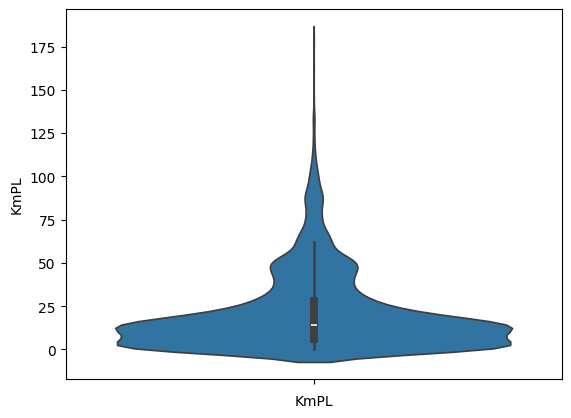

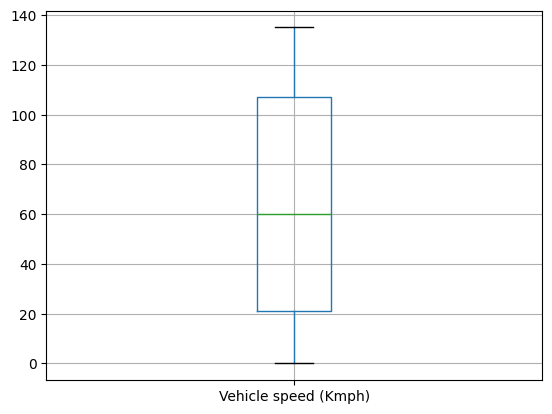

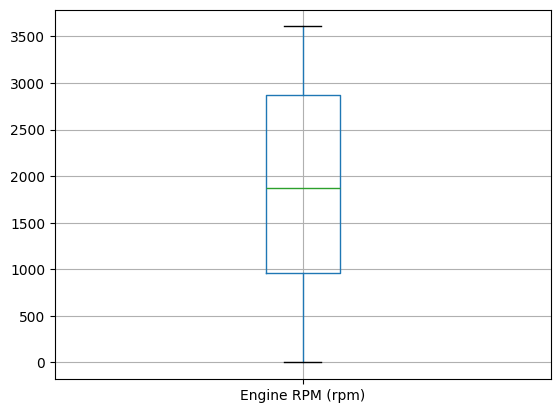

In [6]:
label = 'KmPL'
#RPM과 속도에서 MPG 예측
sns.violinplot(data=datafu[label])
plt.xlabel(label)
plt.show()
datafu.boxplot('Vehicle speed (Kmph)')
plt.show()
datafu.boxplot('Engine RPM (rpm)')
plt.show()

## 데이터 리포맷

차량의 속도, 가속, 및 RPM을 연비를 예측하기 위한 변수로 사용한다.

In [7]:
rpm = 'Engine RPM (rpm)'
speed = 'Vehicle speed (Kmph)'
speeds = datafu[speed].dropna()
acel = 'Vehicle acceleration (g)'
gal = 'Fuel used (gallon)'
alls = [acel,speed,rpm,label]
datar = datafu[alls].copy()

datar

,Vehicle acceleration (g),Vehicle speed (Kmph),Engine RPM (rpm),KmPL
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,0.0,0.0,NaN,0.0
4,NaN,NaN,741.0,NaN
...,...,...,...,...
49597,0.0,0.0,NaN,0.0
49598,NaN,NaN,0.0,NaN
49599,NaN,NaN,NaN,NaN
49600,NaN,NaN,NaN,NaN


## 데이터 이상치 제거

In [8]:
datar.isna().sum()
datan = datar.copy().ffill().drop_duplicates()
datan = datan[datan[label]>0]
datan = datan[datan[label]<45] #이 수치보다 높은 것은 클러치를 단절하고 주행하는 것이다.

datan

,Vehicle acceleration (g),Vehicle speed (Kmph),Engine RPM (rpm),KmPL
452,0.009428,1.0,922.0,0.392853
453,0.009428,1.0,1145.0,0.392853
457,0.028576,3.0,1145.0,3.592926
458,0.028576,3.0,1092.0,3.592926
462,0.027940,3.0,1092.0,4.351105
...,...,...,...,...
49135,-0.044297,5.0,766.0,6.493050
49136,-0.044297,5.0,770.0,6.493050
49140,-0.045524,3.0,770.0,4.001255
49141,-0.045524,3.0,760.0,4.001255


## 상관계수 히트맵 시각화 차트

> 상관계수(相關係數, 영어: correlation coefficient): 두 변수 사이의 통계적 관계를 표현하기 위해 특정한 상관 관계의 정도를 수치적으로 나타낸 계수

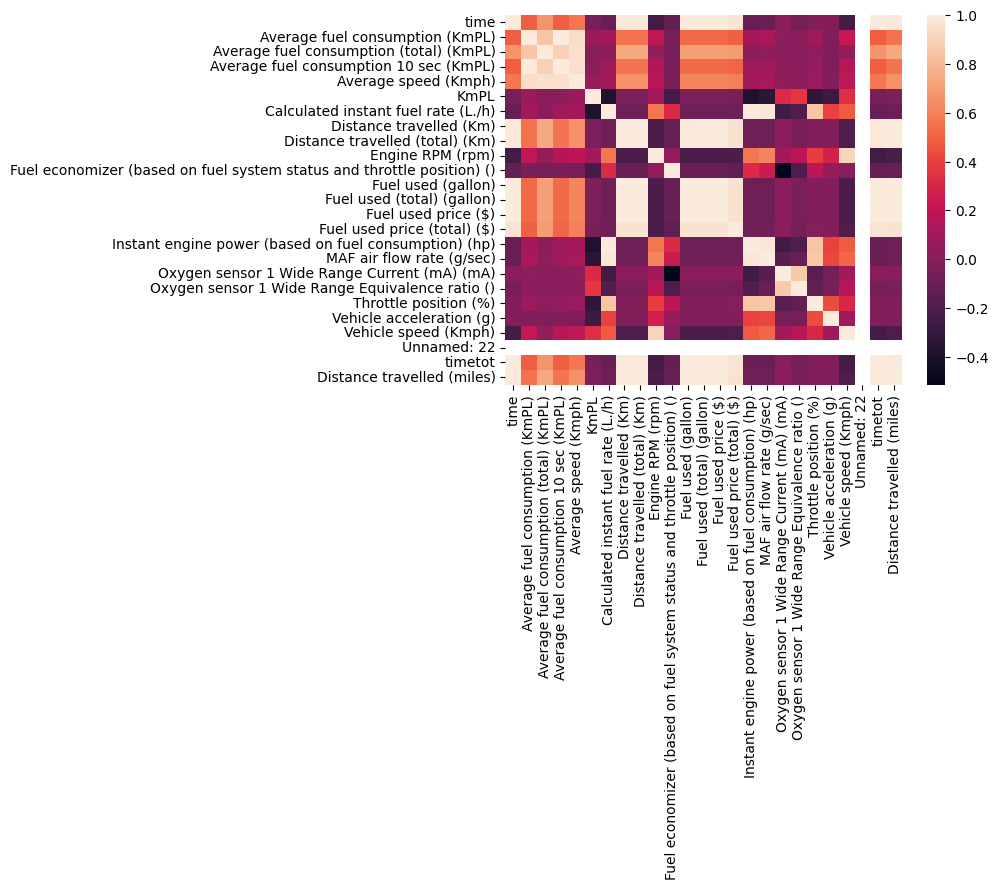

KmPL                                                                      1.000000
Oxygen sensor 1 Wide Range Equivalence ratio ()                           0.362270
Vehicle speed (Kmph)                                                      0.332039
Oxygen sensor 1 Wide Range Current (mA) (mA)                              0.314868
Engine RPM (rpm)                                                          0.098668
Average fuel consumption (KmPL)                                           0.067279
Average speed (Kmph)                                                      0.062504
Average fuel consumption 10 sec (KmPL)                                    0.010824
Average fuel consumption (total) (KmPL)                                   0.006715
Distance travelled (miles)                                               -0.032117
Distance travelled (Km)                                                  -0.032117
Distance travelled (total) (Km)                                          -0.032117
Fuel

In [9]:
datafu_corr = datafu.copy().ffill().drop_duplicates().corr()
sns.heatmap(datafu_corr,annot=False,fmt='f')
plt.show()

datafu_corr["KmPL"].sort_values(axis=0, ascending=False)

## 페어플롯 생성  

> 페어플롯(Pair Plot): pairplot 그래프는 데이터셋에서 모든 수치형 변수들 간의 산점도와 히스토그램을 한눈에 시각화하는 데 사용

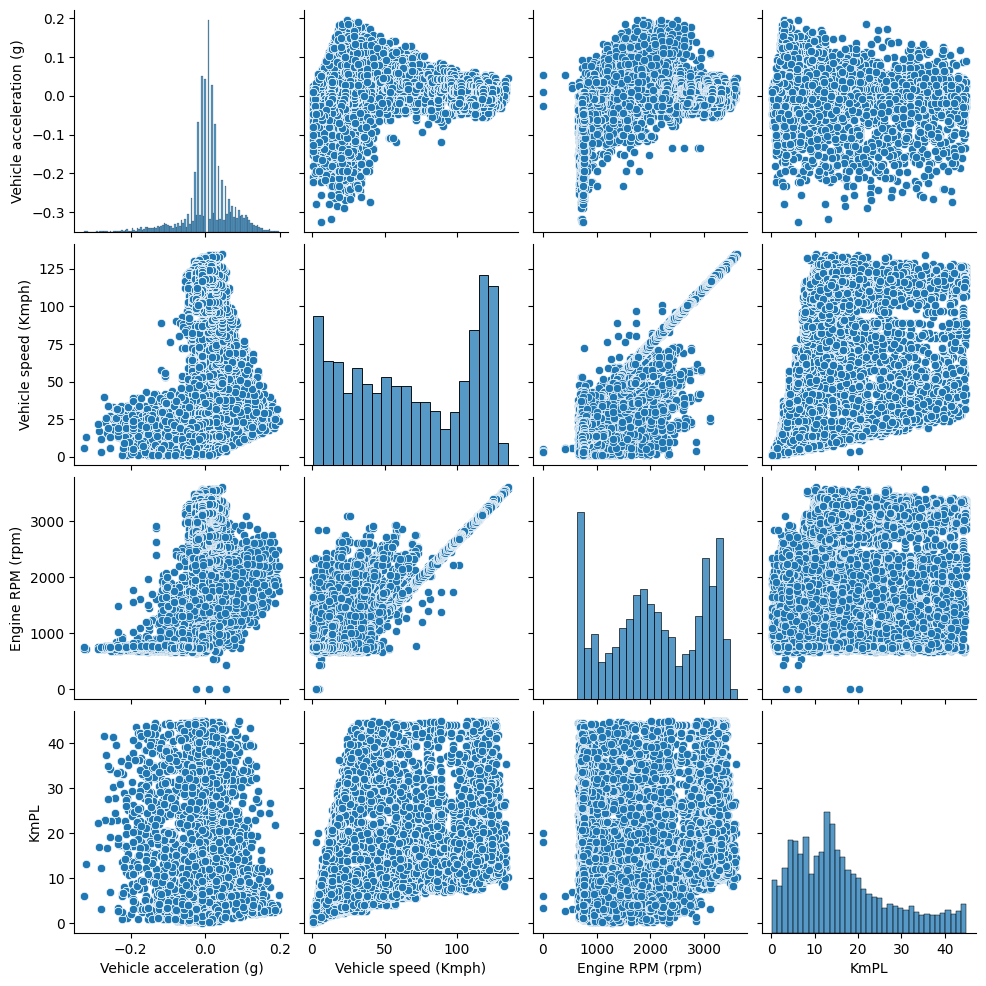

In [10]:
sns.pairplot(datan)
plt.show()

## 데이터 정규화

In [11]:
s = mms() # min-max regularization

use = alls.copy()
use.remove('KmPL')
dataS = pd.DataFrame(np.sqrt(np.array(s.fit_transform(datan))), columns =alls)

dataS

,Vehicle acceleration (g),Vehicle speed (Kmph),Engine RPM (rpm),KmPL
0,0.801078,0.000000,0.505653,0.072736
1,0.801078,0.000000,0.563495,0.072736
2,0.823710,0.122169,0.563495,0.276865
3,0.823710,0.122169,0.550299,0.276865
4,0.822967,0.122169,0.550299,0.305879
...,...,...,...,...
13346,0.733863,0.172774,0.460894,0.375938
13347,0.733863,0.172774,0.462096,0.375938
13348,0.732257,0.122169,0.462096,0.292849
13349,0.732257,0.122169,0.459086,0.292849


## 데이터셋 나누기

In [12]:
Xtrain, Xtest, ytrain, ytest = tts(dataS[use], dataS[label], test_size = .2, random_state = 87)

## 모델 선정

>**XGBoost(eXtra Gradient Boost)**
>트리 기반의 알고리즘의 앙상블 학습에서 각광받는 알고리즘 중 하나로 GBM에 기반하고 있지만,
>GBM의 단점인 느린 수행시간, 과적합 규제 등을 해결한 알고리즘


**XGBoost의 주요장점**  
(1) 뛰어난 예측 성능  
(2) GBM 대비 빠른 수행 시간  
(3) 과적합 규제(Overfitting Regularization)  
(4) Tree pruning(트리 가지치기) : 긍정 이득이 없는 분할을 가지치기해서 분할 수를 줄임  
(5) 자체 내장된 교차 검증  

In [13]:
MLmodel = xgb.XGBRegressor(n_estimators=50, ## 붓스트랩 샘플 개수 또는 base_estimator 개수
            max_depth=15, ## 개별 나무의 최대 깊이
            gamma = 0, ## gamma
            importance_type='gain', ## gain, weight, cover, total_gain, total_cover
            reg_lambda = 1, ## tuning parameter of l2 penalty
            random_state=100
        )

## 모델 학습

In [14]:
m = MLmodel.fit(dataS[use], dataS[label])

## 데이터 예측 및 평가

0.07319 1.237, r2=0.9364661861186863


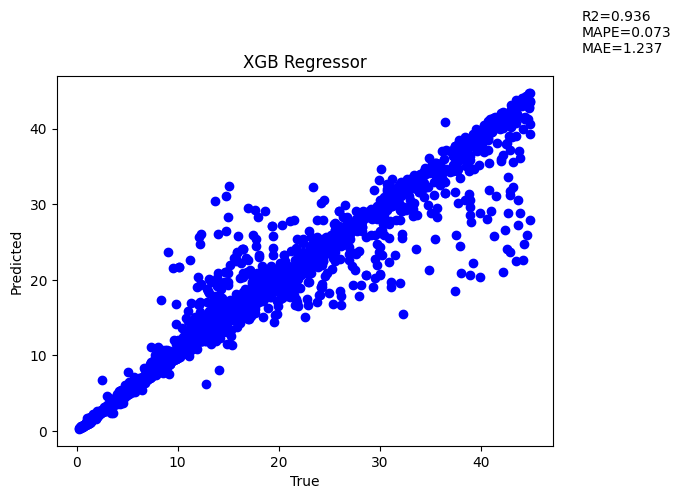

In [15]:
# 데이터 예측
datatest = Xtest.join(ytest,how='right')

yp = m.predict(datatest[use])

# 모델 평가
unscaled = pd.DataFrame(s.inverse_transform((datatest.values)**2),columns = alls)
datap = datatest.copy()
datap[label] = yp
unscaledy = unscaled[label]
unscaledp = pd.DataFrame(s.inverse_transform(datap.values**2),columns=alls)[label]
perc = MAPE(unscaledy, unscaledp)

scoree = MAE(unscaledy, unscaledp)
scorer = r2(unscaledy, unscaledp)
plt.plot(unscaledy, unscaledp, 'bo')
plt.text(50,50,f'R2={round(scorer,3)}\nMAPE={round(perc,3)}\nMAE={round(scoree,3)}')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('XGB Regressor')
print(f'{perc:.4g}',f'{scoree:.4g}, r2={scorer}')

In [16]:
MLmodel_path = './xgb_reg_model.json'
m.save_model(MLmodel_path)

In [17]:
# Blank new instance to be loaded into
xbg_reg = xgb.XGBRegressor()
xbg_reg.load_model(MLmodel_path)

0.07319 1.237, r2=0.9364661861186863


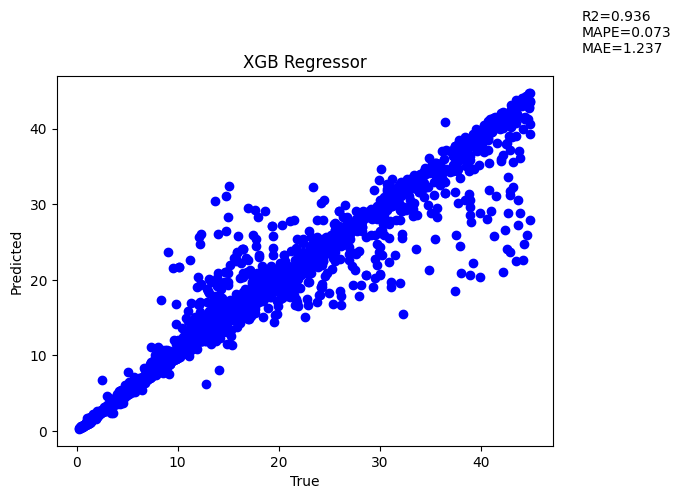

In [18]:
yp = xbg_reg.predict(datatest[use])

# 모델 평가
unscaled = pd.DataFrame(s.inverse_transform((datatest.values)**2),columns = alls)
datap = datatest.copy()
datap[label] = yp
unscaledy = unscaled[label]
unscaledp = pd.DataFrame(s.inverse_transform(datap.values**2),columns=alls)[label]
perc = MAPE(unscaledy, unscaledp)

scoree = MAE(unscaledy, unscaledp)
scorer = r2(unscaledy, unscaledp)
plt.plot(unscaledy, unscaledp, 'bo')
plt.text(50,50,f'R2={round(scorer,3)}\nMAPE={round(perc,3)}\nMAE={round(scoree,3)}')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('XGB Regressor')
print(f'{perc:.4g}',f'{scoree:.4g}, r2={scorer}')

# 딥러닝을 활용한 선형회귀 모델

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

## GPU 사용을 위해 텐서로 데이터 변환

In [20]:
device = torch.device('cuda')

Xtrain_tensor = torch.FloatTensor(Xtrain.values).to(device)
ytrain_tensor = torch.FloatTensor(ytrain.values.reshape(-1, 1)).to(device)
Xtest_tensor = torch.FloatTensor(Xtest.values).to(device)
ytest_tensor = torch.FloatTensor(ytest.values).to(device)

## 딥러닝 레이어 구성하기

In [21]:
class MultivariateLinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultivariateLinearRegression, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            torch.nn.LeakyReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, output_size)
        )
    
    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x

## 모델 설정 하기

In [22]:
DLmodel = MultivariateLinearRegression(input_size=Xtrain_tensor.shape[1], output_size=1)
DLmodel.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(DLmodel.parameters(), lr=1e-3)

## 모델 요약 보기

In [23]:
from torchinfo import summary

summary(DLmodel, input_size=Xtrain_tensor.shape)

Layer (type:depth-idx)                   Output Shape              Param #
MultivariateLinearRegression             [10680, 1]                --
├─Sequential: 1-1                        [10680, 1]                --
│    └─Linear: 2-1                       [10680, 512]              2,048
│    └─ReLU: 2-2                         [10680, 512]              --
│    └─Linear: 2-3                       [10680, 1024]             525,312
│    └─ReLU: 2-4                         [10680, 1024]             --
│    └─Linear: 2-5                       [10680, 1024]             1,049,600
│    └─LeakyReLU: 2-6                    [10680, 1024]             --
│    └─Linear: 2-7                       [10680, 1024]             1,049,600
│    └─ReLU: 2-8                         [10680, 1024]             --
│    └─Linear: 2-9                       [10680, 512]              524,800
│    └─ReLU: 2-10                        [10680, 512]              --
│    └─Linear: 2-11                      [10680, 1]       

## 모델 학습 하기

epoch : 0, loss : 0.3406727910041809
epoch : 50, loss : 0.027441954240202904
epoch : 100, loss : 0.02102024480700493
epoch : 150, loss : 0.01997043564915657
epoch : 200, loss : 0.021356754004955292
epoch : 250, loss : 0.019193492829799652
epoch : 300, loss : 0.019352979958057404
epoch : 350, loss : 0.01898352801799774
epoch : 400, loss : 0.01919589191675186
epoch : 450, loss : 0.01878448948264122
epoch : 500, loss : 0.018742378801107407
epoch : 550, loss : 0.018921786919236183
epoch : 600, loss : 0.018792344257235527
epoch : 650, loss : 0.018568435683846474
epoch : 700, loss : 0.01871628873050213
epoch : 750, loss : 0.018933376297354698
epoch : 800, loss : 0.019200006499886513
epoch : 850, loss : 0.01941400021314621
epoch : 900, loss : 0.01847250387072563
epoch : 950, loss : 0.018542524427175522


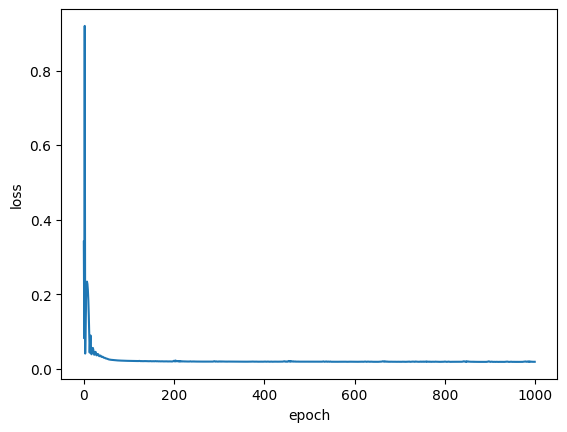

In [24]:
num_epochs = 1000
loss_list = []
for epoch in range(num_epochs):
    y_pred = DLmodel(Xtrain_tensor)
    loss = criterion(ytrain_tensor, y_pred)
 
    # 역전파
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
 
    loss_list.append(loss.item())
    if epoch % 50 == 0:
        print(f'epoch : {epoch}, loss : {loss.item()}')

pd.Series(loss_list).plot()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# 모델 저장기
torch.save(DLmodel.state_dict(), "./Model_3var_OBD.pth")

## 모델 읽어오기

In [27]:
DLmodel = MultivariateLinearRegression(input_size=Xtrain_tensor.shape[1], output_size=1)
DLmodel.load_state_dict(torch.load("./Model_3var_OBD.pth"))
DLmodel.to(device)

MultivariateLinearRegression(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=1, bias=True)
  )
)

## 모델 평가하기

val_loss : 0.07246992737054825
0.1995 4.69, r2=0.5649455954620279


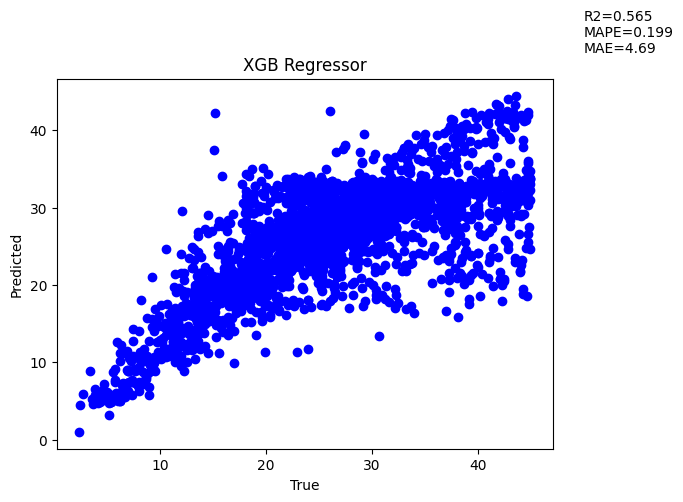

In [30]:
with torch.no_grad():
    ytest_pred = DLmodel(Xtest_tensor).cpu()
    print(f'val_loss : {criterion(ytest_tensor.cpu(), ytest_pred).item()}')

unscaled = pd.DataFrame(s.inverse_transform(datatest),columns = alls)
datap = datatest.copy()
datap[label] = ytest_pred
unscaledy = unscaled[label]
unscaledp = pd.DataFrame(s.inverse_transform(datap),columns=alls)[label]
perc = MAPE(unscaledy, unscaledp)

scoree = MAE(unscaledy, unscaledp)
scorer = r2(unscaledy, unscaledp)
plt.plot(unscaledy, unscaledp, 'bo')
plt.xlabel('True')
plt.text(50,50,f'R2={round(scorer,3)}\nMAPE={round(perc,3)}\nMAE={round(scoree,3)}')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('XGB Regressor')
print(f'{perc:.4g}',f'{scoree:.4g}, r2={scorer}')